# <center>**Đồ án 3: Linear Regression**</center>

# **Thông tin sinh viên**

- Họ và tên : Dương Quang Thắng
- MSSV : 22127384
- Lớp : 22CLC09

# **Khai báo thư viện**

In [13]:
import pandas as pd
import numpy as np

# Import thêm thư viện
from sklearn import linear_model
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt

# **Đọc dữ liệu**

In [14]:
# Đọc dữ liệu bằng pandas
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Lấy các đặc trưng X và giá trị mục tiêu y cho các tập huấn luyện (train) và kiểm tra (test)
X_train = train.iloc[:, :-1]            # Dataframe (chứa 5 đặc trưng huấn luyện)
y_train = train.iloc[:, -1]             # Series    (chứa 1 giá trị mục tiêu huấn luyện)

X_test = test.iloc[:, :-1]              # Dataframe (chứa 5 đặc trưng kiểm tra)
y_test = test.iloc[:, -1]               # Series    (chứa 1 giá trị mục tiêu kiểm tra)

# Chuyển DataFrame sang numpy array
features = X_train.to_numpy()
performance_index = y_train.to_numpy()

In [15]:
train.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,77,0,5,2,69.0
1,8,90,1,4,1,84.0
2,9,83,1,6,3,82.0
3,4,52,0,9,5,38.0
4,4,82,1,8,6,68.0


# **Cài đặt hàm**

In [16]:
def plot_features(df):
    """
    Vẽ biểu đồ phân tán giữa các đặc trưng và biến mục tiêu trong DataFrame.
    
    Tham số:
    df (pandas.DataFrame): DataFrame chứa các đặc trưng và biến mục tiêu.
    
    Trả về:
    None
    """
    sns.pairplot(df, kind="scatter", diag_kind="kde")  
    plt.show()
    
    
def plot_correlation_matrix(df):
    """
    Vẽ ma trận tương quan giữa các đặc trưng trong DataFrame dưới dạng biểu đồ nhiệt.
    
    Tham số:
    df (pandas.DataFrame): DataFrame chứa các đặc trưng.
    
    Trả về:
    None
    """
    plt.figure(figsize=(12, 10))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix')
    plt.show()
    

def plot_histogram(df):
    """
    Vẽ biểu đồ histogram cho phân phối của các đặc trưng trong DataFrame.
    
    Tham số:
    df (pandas.DataFrame): DataFrame chứa các đặc trưng và biến mục tiêu.
    
    Trả về:
    None
    """
    features = df.columns[:-1]
    plt.figure(figsize=(15, 10))
    for idx, feature in enumerate(features, start=1):
        plt.subplot(3, 2, idx)
        sns.histplot(train[feature], kde=True)
        plt.title(f'Distribution of {feature}')
    plt.tight_layout()
    plt.show()
    
    
def plot_linechart(df):
    """
    Vẽ biểu đồ đường để so sánh các đặc trưng với biến mục tiêu trong DataFrame.
    
    Tham số:
    df (pandas.DataFrame): DataFrame chứa các đặc trưng và biến mục tiêu.
    
    Trả về:
    None
    """
    performance_index = df.columns[-1]
    
    features = ['Hours Studied', 'Sleep Hours', 'Previous Scores', 'Sample Question Papers Practiced']
    
    for feature in features:
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=df, x=feature, y=performance_index)
        plt.xlabel(feature)
        plt.ylabel(performance_index)
        plt.title(f'{feature} vs {performance_index}')
        plt.show()
    

def calculate_mae(X, y, k=5):
    """
    Tính toán Mean Absolute Error (MAE) bằng phương pháp K-Fold Cross-Validation.
    
    Tham số:
    X (numpy.ndarray): Mảng numpy chứa các đặc trưng huấn luyện.
    y (numpy.ndarray): Mảng numpy chứa các giá trị mục tiêu huấn luyện.
    k (int, tùy chọn): Số lượng folds trong K-Fold Cross-Validation (mặc định là 5).
    
    Trả về:
    float: MAE trung bình qua các folds.
    """
    mae_scores = []
    k_fold = KFold(n_splits=k, shuffle=True, random_state=42)

    for train_index, val_index in k_fold.split(X):
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]

        model = linear_model.LinearRegression().fit(X_train_fold, y_train_fold)
        y_val_pred = model.predict(X_val_fold)

        mae = mean_absolute_error(y_val_fold, y_val_pred)
        mae_scores.append(mae)

    return np.mean(mae_scores)


def find_best_feature(df, y, k):
    """
    Tìm đặc trưng tốt nhất dựa trên MAE qua K-Fold Cross-Validation.
    
    Tham số:
    df (pandas.DataFrame): DataFrame chứa các đặc trưng và biến mục tiêu.
    y (pandas.Series): Series chứa các giá trị mục tiêu.
    k (int): Số lượng folds trong K-Fold Cross-Validation.
    
    Trả về:
    tuple: Đặc trưng tốt nhất và danh sách các MAE cho từng đặc trưng.
    """
    mae_results = []
    feature_names = df.columns[:-1]

    for feature_index in feature_names:
        X_feature = df[[feature_index]].to_numpy()
        average_mae = calculate_mae(X_feature, y, k)
        mae_results.append((feature_index, average_mae))

    mae_results.sort(key=lambda x: x[1])
    best_feature = mae_results[0][0] 
    return best_feature, mae_results


def print_mae_results(mae_results):
    """
    In kết quả MAE cho từng đặc trưng.
    
    Tham số:
    mae_results (list of tuple): Danh sách chứa các đặc trưng và MAE tương ứng.
    
    Trả về:
    None
    """
    print(f"| {'Order':^3} | {'Feature':^35} | {'MAE':^6} |")
    print(f"|{'-'*7}|{'-'*37}|{'-'*8}|")
    for idx, (feature, mae) in enumerate(mae_results, start=1):  
        print(f"|{idx:^6} | {feature:<35} | {mae:^6.3f} |")

# **Yêu cầu 1: Phân tích khám phá dữ liệu**

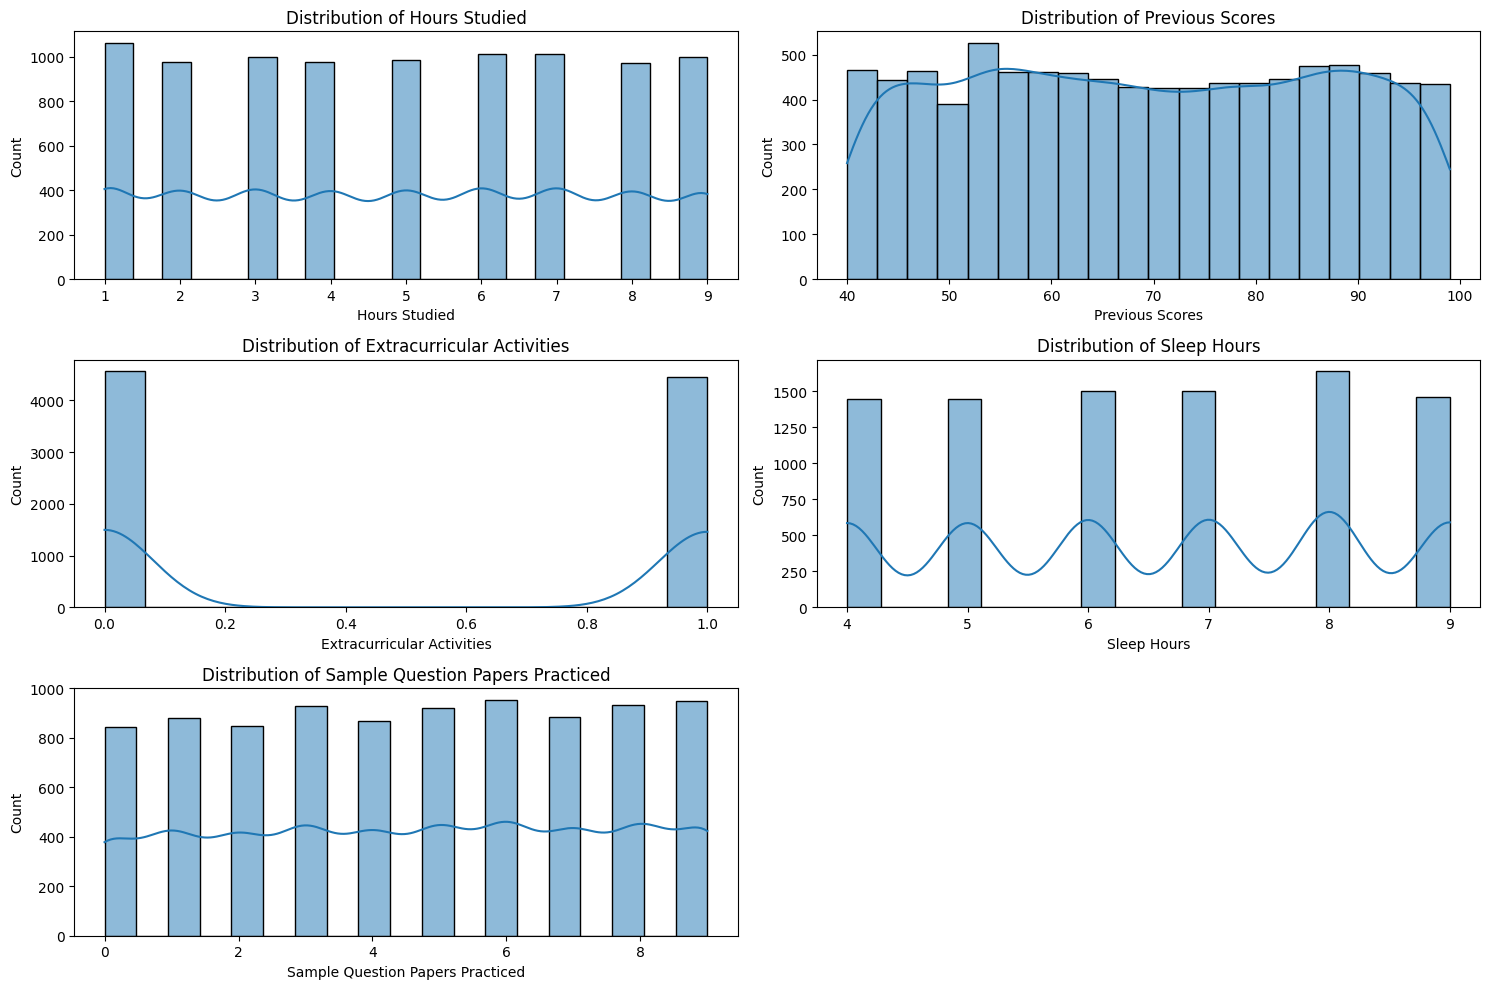

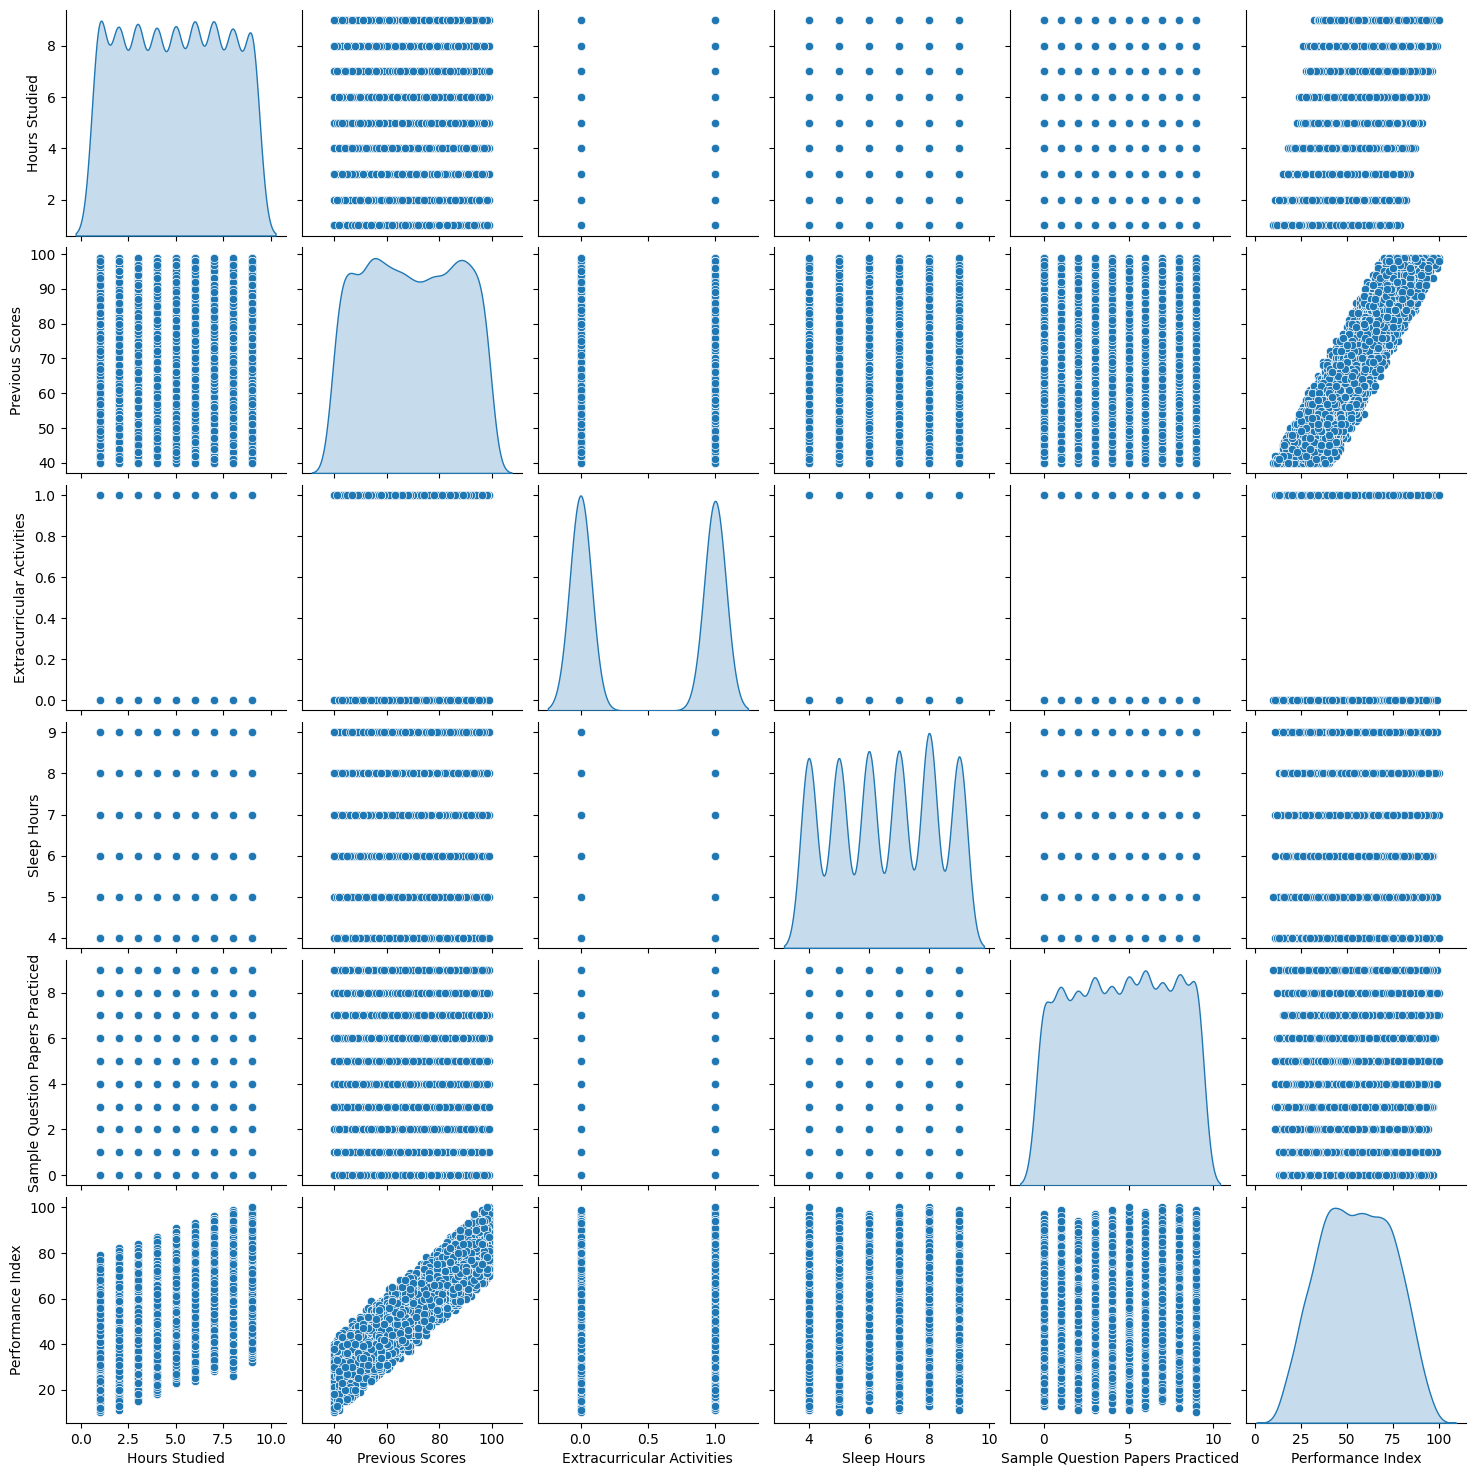

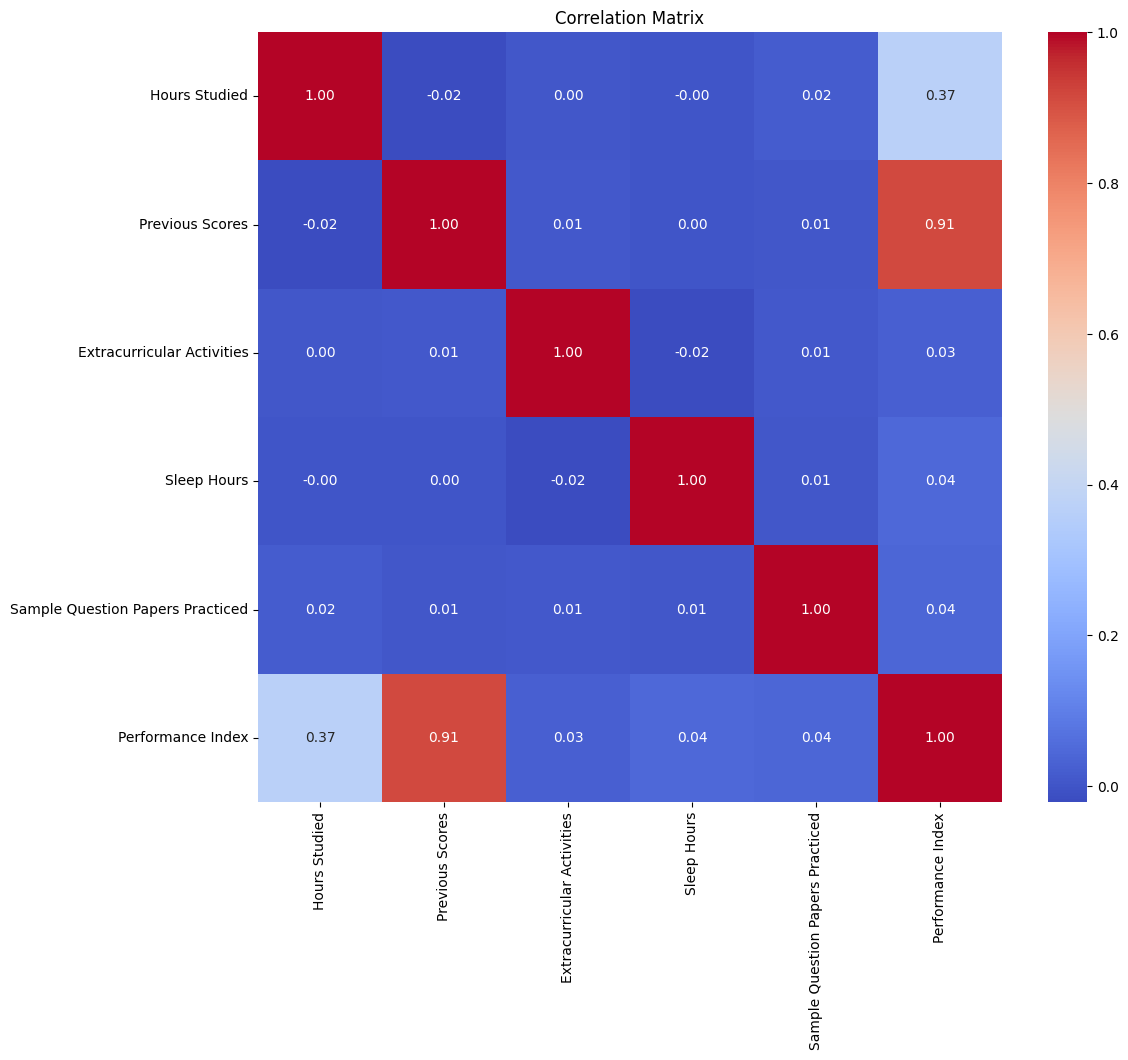

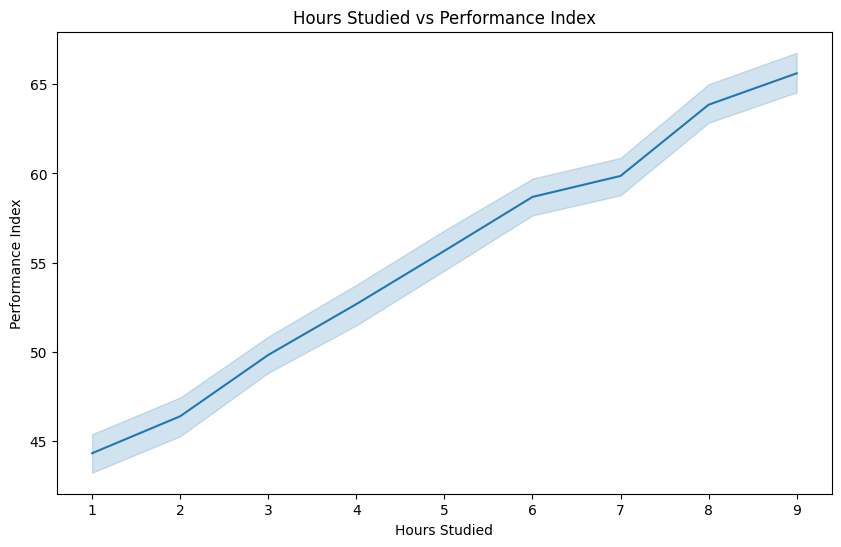

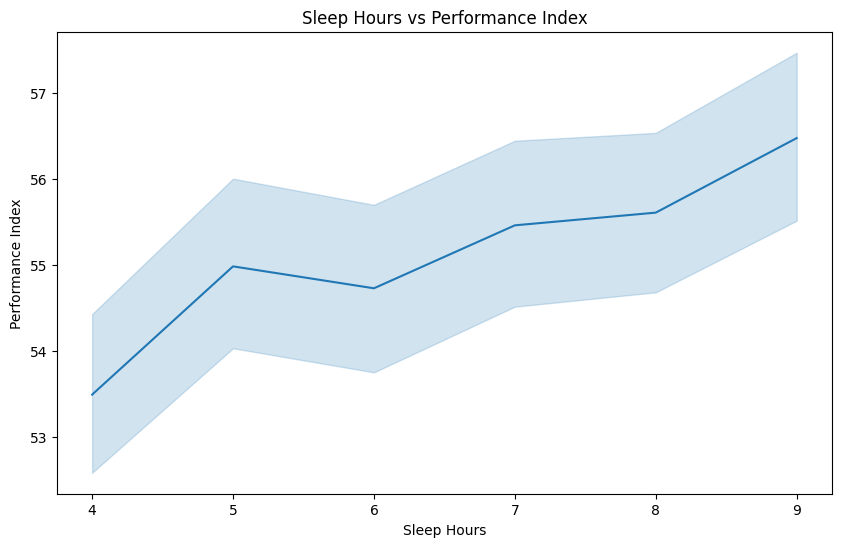

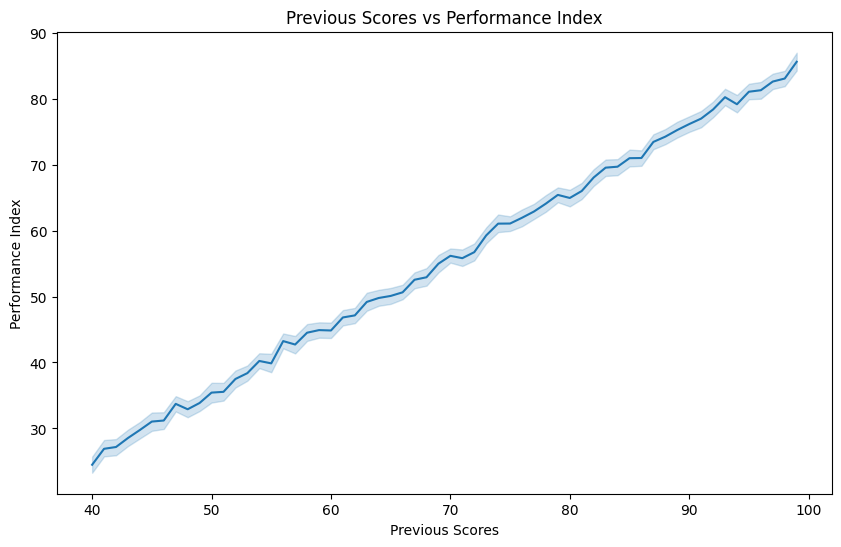

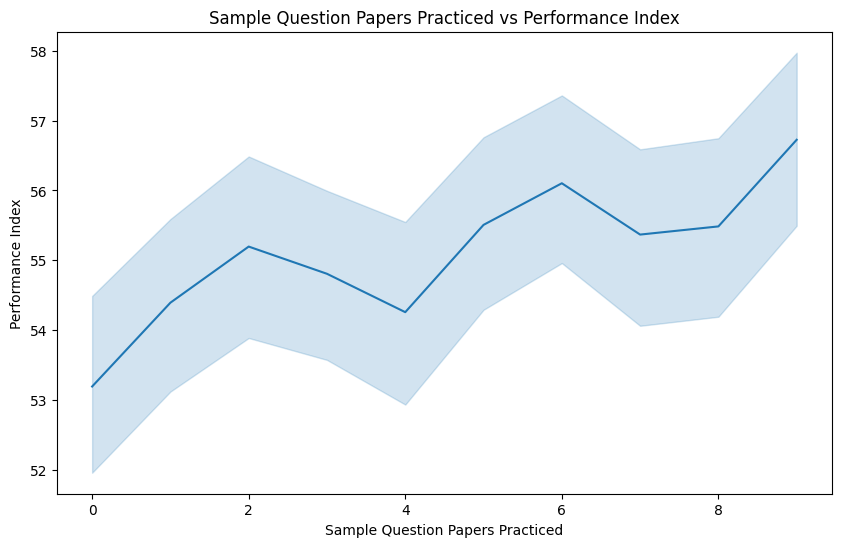

<Axes: xlabel='Extracurricular Activities', ylabel='Performance Index'>

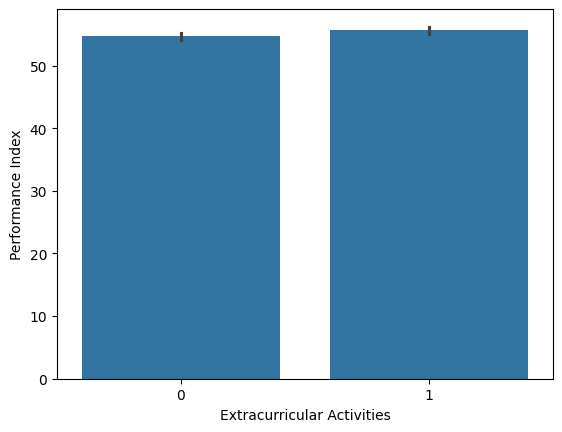

In [17]:
# Phân tích phân phối của từng đặc trưng bằng biểu đồ histogram
plot_histogram(train)

# Biểu đồ phân tán giữa các đặc trưng và Performance index 
plot_features(train)

# Phân tích ma trận tương quan
plot_correlation_matrix(train)
        
# Biểu đồ đường
plot_linechart(train)

# Biểu đồ bar
sns.barplot(train, x='Extracurricular Activities', y='Performance Index')

# **Yêu cầu 2a: Xây dựng mô hình sử dụng toàn bộ 5 đặc trưng**

In [18]:
# Huấn luyện mô hình
model = linear_model.LinearRegression().fit(features, performance_index)

In [19]:
# Dự đoán trên tập dữ liệu test
y_pred = model.predict(X_test.to_numpy())

# Gọi hàm MAE trên tập kiểm tra
mae = mean_absolute_error(y_test, y_pred)

print(f"MAE: {mae}")

MAE: 1.5956486884762975


Công thức hồi quy:

$$\text{Student Performance} = 2.852 \cdot \text{Hours Studied} + 1.018 \cdot \text{Previous Scores} + 0.604 \cdot \text{Extracurricular Activities} \\ + 0.474 \cdot \text{Sleep Hours} + 0.192 \cdot \text{Sample Question Papers Practiced} - 33.969$$

# **Yêu cầu 2b: Xây dựng mô hình sử dụng duy nhất 1 đặc trưng cho kết quả tốt nhất**

In [20]:
# Tìm đặc trưng tốt nhất (trong 5 đặc trưng)
best_feature, mae_results = find_best_feature(train, performance_index, k=5)

# In kết quả MAE cho từng đặc trưng
print_mae_results(mae_results)

| Order |               Feature               |  MAE   |
|-------|-------------------------------------|--------|
|  1    | Previous Scores                     | 6.618  |
|  2    | Hours Studied                       | 15.449 |
|  3    | Sleep Hours                         | 16.187 |
|  4    | Sample Question Papers Practiced    | 16.188 |
|  5    | Extracurricular Activities          | 16.196 |


In [21]:
# Huấn luyện lại mô hình best_feature_model với đặc trưng tốt nhất trên toàn bộ tập huấn luyện
best_feature_model = linear_model.LinearRegression()
best_feature_model.fit(train[[best_feature]], performance_index)

LinearRegression()

In [22]:
# Dự đoán trên tập dữ liệu test
y_val_pred = best_feature_model.predict(X_test[[best_feature]])

# Gọi hàm MAE trên tập kiểm tra với mô hình best_feature_model
best_mae = mean_absolute_error(y_test, y_val_pred)
print(f"MAE: {best_mae}")

MAE: 6.544277293452501


Công thức hồi quy:

$$\text{Student Performance} = 1.011 \cdot \text{Previous Scores} - 14.989$$

# **Yêu cầu 2c: Xây dựng mô hình cho kết quả tốt nhất**

# Xây dựng/Thiết kế mô hình

In [23]:
def create_models(train):
    """
    Tạo các mô hình với các tập hợp đặc trưng khác nhau từ DataFrame huấn luyện.
    
    Tham số:
    train (pandas.DataFrame): DataFrame chứa các đặc trưng và biến mục tiêu.
    
    Trả về:
    tuple: Các mảng numpy chứa các đặc trưng cho từng mô hình.
    """
    X_model_1 = train[['Hours Studied', 'Previous Scores', 'Sample Question Papers Practiced']].to_numpy()

    scaler = StandardScaler()
    X_model_2_scaled = scaler.fit_transform(train[['Hours Studied', 'Previous Scores']])
    X_model_2 = np.hstack((X_model_2_scaled, train[['Sleep Hours', 'Sample Question Papers Practiced']].to_numpy()))

    HS_PS = (train['Hours Studied'] * train['Previous Scores']).values.reshape(-1, 1)
    EA_SH = (train['Extracurricular Activities'] * train['Sleep Hours']).values.reshape(-1, 1)
    X_model_3 = np.hstack((HS_PS, EA_SH))

    return X_model_1, X_model_2, X_model_3


def evaluate_models(X_model_1, X_model_2, X_model_3, y_train):
    """
    Đánh giá các mô hình với các tập hợp đặc trưng khác nhau bằng cách tính toán MAE.
    
    Tham số:
    X_model_1 (numpy.ndarray): Mảng chứa các đặc trưng cho mô hình 1.
    X_model_2 (numpy.ndarray): Mảng chứa các đặc trưng cho mô hình 2.
    X_model_3 (numpy.ndarray): Mảng chứa các đặc trưng cho mô hình 3.
    y_train (pandas.Series): Series chứa các giá trị mục tiêu.
    
    Trả về:
    tuple: Các MAE cho từng mô hình.
    """
    mae_model_1 = calculate_mae(X_model_1, y_train.to_numpy(), k=5)
    mae_model_2 = calculate_mae(X_model_2, y_train.to_numpy(), k=5)
    mae_model_3 = calculate_mae(X_model_3, y_train.to_numpy(), k=5)

    results = [
        ("Sử dụng (Hours Studied, Previous Scores, Sample Question Papers Practiced)", mae_model_1),
        ("Chuẩn hóa và sử dụng 4 đặc trưng", mae_model_2),
        ("Sử dụng 2 đặc trưng mới được tạo", mae_model_3)
    ]

    return results, mae_model_1, mae_model_2, mae_model_3


def print_results(results):
    """
    In kết quả MAE cho các mô hình khác nhau.
    
    Tham số:
    results (list of tuple): Danh sách chứa mô tả mô hình và MAE tương ứng.
    
    Trả về:
    None
    """
    print(f"| {'STT':^3} | {'Mô hình':^80} | {'MAE':^6} |")
    print(f"|{'-'*5}|{'-'*82}|{'-'*8}|")
    for idx, (desc, mae) in enumerate(results, start=1):
        print(f"| {idx:^3} | {desc:<80} | {mae:^6.3f} |")
        

def train_my_best_model(X_train, y_train, X_test, y_test, best_model_index):
    """
    Huấn luyện mô hình tốt nhất và tính toán MAE trên tập dữ liệu kiểm tra.
    
    Tham số:
    X_train (numpy.ndarray): Mảng chứa các đặc trưng huấn luyện.
    y_train (pandas.Series): Series chứa các giá trị mục tiêu huấn luyện.
    X_test (numpy.ndarray): Mảng chứa các đặc trưng kiểm tra.
    y_test (pandas.Series): Series chứa các giá trị mục tiêu kiểm tra.
    best_model_index (int): Chỉ số mô hình tốt nhất.
    
    Trả về:
    tuple: Mô hình tốt nhất và MAE trên tập dữ liệu kiểm tra.
    """
    model = linear_model.LinearRegression()
    model.fit(X_train, y_train)

    # Dự đoán trên tập dữ liệu kiểm tra
    y_test_pred = model.predict(X_test)

    # Tính MAE trên tập dữ liệu kiểm tra
    my_mae = mean_absolute_error(y_test, y_test_pred)

    return model, my_mae


# Mô hình cho kết quả tốt nhất

In [24]:
X_model_1, X_model_2, X_model_3 = create_models(train)

results, mae_model_1, mae_model_2, mae_model_3 = evaluate_models(X_model_1, X_model_2, X_model_3, y_train)
    
print_results(results)


my_best_model_index = np.argmin([mae_model_1, mae_model_2, mae_model_3])
best_model_description = results[my_best_model_index][0]

if my_best_model_index == 0:
    best_X_train = X_model_1
    best_X_test = test[['Hours Studied', 'Previous Scores', 'Sample Question Papers Practiced']].to_numpy()
elif my_best_model_index == 1:
    best_X_train = X_model_2
    scaler = StandardScaler().fit(train[['Hours Studied', 'Previous Scores']])
    best_X_test_scaled = scaler.transform(test[['Hours Studied', 'Previous Scores']])
    best_X_test = np.hstack((best_X_test_scaled, test[['Sleep Hours', 'Sample Question Papers Practiced']].to_numpy()))
else:
    best_X_train = X_model_3
    HS_PS_test = (test['Hours Studied'] * test['Previous Scores']).values.reshape(-1, 1)
    EA_SH_test = (test['Extracurricular Activities'] * test['Sleep Hours']).values.reshape(-1, 1)
    best_X_test = np.hstack((HS_PS_test, EA_SH_test))

# Huấn luyện và đánh giá mô hình tốt nhất
my_best_model, my_mae = train_my_best_model(best_X_train, y_train, best_X_test, y_test, my_best_model_index)
print(f"MAE: {my_mae}")

| STT |                                     Mô hình                                      |  MAE   |
|-----|----------------------------------------------------------------------------------|--------|
|  1  | Sử dụng (Hours Studied, Previous Scores, Sample Question Papers Practiced)       | 1.760  |
|  2  | Chuẩn hóa và sử dụng 4 đặc trưng                                                 | 1.642  |
|  3  | Sử dụng 2 đặc trưng mới được tạo                                                 | 11.077 |
MAE: 1.613687590481988


Công thức hồi quy:

$$\text{Student Performance} = 7.4 \cdot \text{Hours Studied} + 17.682\cdot \text{Previous Scores} + 0.469 \cdot \text{Sleep Hours} \\ + 0.193 \cdot \text{Sample Question Papers Practiced} + 51.178$$